# Clustering in SKU Segmentation
This is an attempt to pipeline the model. The aim is to obtain the best algorithm based on the external performance evaluation metrics as it can be realised upon looking in the data that there is a lack of ground truth.

The script utilizes a free software machine learning library “scikit-learn” as a core
complementing it with several algorithms.
The script uses the concept of data-pipeline to consequentially perform the following procedures:
1. to impute the missing data with Multivariate Imputation
2. to standardize the data
3. to identify and trim outliers and small 'blobs' with Isolation Forest
4. to cluster the data with k-mean, BIRCH and Affinity Propagation
5. to improve the eventual clustering result via PCA

Since the ground truth is not provided, the clustering is validated only by internal evaluation, namely by silhouette index, Calinski-Harabazs index and Davies-Bouldin.

In [1]:
import pandas as pd
import numpy as np
import csv

In [2]:
from google.colab import files
uploaded = files.upload()

Saving initial_data.xlsx to initial_data (2).xlsx


# Importing the file
The file uploaded is in .xlsx format. This needs to be converted accordingly in a dataframe so that pandas operations could be performed. 
Pandas library based operations will enable a preliminary analysis and operations inside the dataframe.
Here, 3 columns are dropped due to unfavourability in contribution to arrangement.

In [3]:
import io
data = pd.read_excel(io.BytesIO(uploaded['initial_data.xlsx']))

data[['Unitprice', 'Expire date', 'Outbound number','Total outbound','Pal grossweight', 'Pal height',
      'Units per pal']] = data[['Unitprice', 'Expire date', 'Outbound number','Total outbound','Pal grossweight',
                                'Pal height', 'Units per pal']].replace(0.0, np.nan)
data = data.drop(["ID","Tradability","Init status"], axis=1)
data.head(10)


,Unitprice,Expire date,Outbound number,Total outbound,Pal grossweight,Pal height,Units per pal
0,0.0580,547.0,9.0,2441.0,105.60,1.56,1920.0
1,0.9540,547.0,NaN,NaN,207.68,1.00,384.0
2,2.3850,547.0,12.0,23.0,165.78,1.02,108.0
3,5.1000,547.0,NaN,NaN,221.04,1.05,72.0
4,NaN,547.0,NaN,NaN,NaN,NaN,NaN
5,1.1100,547.0,1.0,1.0,207.68,1.00,384.0
6,2.5150,547.0,2.0,4.0,165.78,1.02,108.0
7,NaN,547.0,NaN,NaN,NaN,NaN,NaN
8,0.2625,547.0,NaN,NaN,NaN,NaN,NaN
9,13.3540,365.0,NaN,NaN,441.72,1.44,36.0


# Checking for null values
The null values obtained are in NaN character and have to be subsequently imputed. 

In [4]:
data.isnull()

,Unitprice,Expire date,Outbound number,Total outbound,Pal grossweight,Pal height,Units per pal
0,False,False,False,False,False,False,False
1,False,False,True,True,False,False,False
2,False,False,False,False,False,False,False
3,False,False,True,True,False,False,False
4,True,False,True,True,True,True,True
...,...,...,...,...,...,...,...
2274,True,True,True,True,False,True,False
2275,True,True,False,False,False,True,False
2276,True,True,True,True,False,True,False
2277,True,True,False,False,False,True,False


# Contribution of each feature
The following shows how many null values are contributed by each feature in the observations. They can be unique (only a single feature has a null value) or repititive (an observation having multiple null values across its features)

In [5]:
data.isnull().sum()

Unitprice          710
Expire date        529
Outbound number    979
Total outbound     979
Pal grossweight    371
Pal height         787
Units per pal      295
dtype: int64

# Calculating the Pearson Correlation matrix
As part of a preliminary analysis to establish any strong or medium correlation amongst various feature that could impact the final performance.


In [6]:
data.corr(method ='pearson')

,Unitprice,Expire date,Outbound number,Total outbound,Pal grossweight,Pal height,Units per pal
Unitprice,1.000000,-0.648809,-0.056527,-0.084959,0.184989,-0.031787,-0.034507
Expire date,-0.648809,1.000000,0.141444,0.112660,-0.311792,-0.415777,0.309733
Outbound number,-0.056527,0.141444,1.000000,0.851717,0.075129,-0.072312,-0.040111
Total outbound,-0.084959,0.112660,0.851717,1.000000,-0.026515,-0.019687,-0.006720
Pal grossweight,0.184989,-0.311792,0.075129,-0.026515,1.000000,0.412455,0.070743
Pal height,-0.031787,-0.415777,-0.072312,-0.019687,0.412455,1.000000,-0.030092
Units per pal,-0.034507,0.309733,-0.040111,-0.006720,0.070743,-0.030092,1.000000


# Trimming the number of features
Since the feature "Outbound Number" and "Total Outbound" is strongly correlated, they are merged into a single feature called "Outbound Fraction", which will contribute on behalf of the dropped features.


In [7]:
data['Outbound Fraction'] = data['Total outbound']/data['Outbound number']
data = data.drop(['Outbound number','Total outbound'],axis = 1)
data.head()

,Unitprice,Expire date,Pal grossweight,Pal height,Units per pal,Outbound Fraction
0,0.058,547.0,105.60,1.56,1920.0,271.222222
1,0.954,547.0,207.68,1.00,384.0,NaN
2,2.385,547.0,165.78,1.02,108.0,1.916667
3,5.100,547.0,221.04,1.05,72.0,NaN
4,NaN,547.0,NaN,NaN,NaN,NaN


# Rechecking for any correlation
Repeating the exercise for any strong pearson correlation

In [8]:
data.corr(method ='pearson')

,Unitprice,Expire date,Pal grossweight,Pal height,Units per pal,Outbound Fraction
Unitprice,1.000000,-0.648809,0.184989,-0.031787,-0.034507,-0.085157
Expire date,-0.648809,1.000000,-0.311792,-0.415777,0.309733,0.009647
Pal grossweight,0.184989,-0.311792,1.000000,0.412455,0.070743,-0.231229
Pal height,-0.031787,-0.415777,0.412455,1.000000,-0.030092,0.248131
Units per pal,-0.034507,0.309733,0.070743,-0.030092,1.000000,0.073829
Outbound Fraction,-0.085157,0.009647,-0.231229,0.248131,0.073829,1.000000


In [9]:
columns = ['UnitPrice','ExpiryDate','Pal Grossweight','Pal Height','Units per pal','Outbound Fraction']
index = list(range(1,2280,1))

# Imputation
Here we attempt to impute the null values, using iterative imputer and that uses a multivariate imputer using chained equations.
Multivariate imputer that estimates each feature from all the others. The initial strategy is set as mean.

In [10]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(initial_strategy = 'mean')
d1 = imp.fit_transform(data)

## The imputed data set

In [11]:
df = pd.DataFrame(d1,index,columns)
df.head()

,UnitPrice,ExpiryDate,Pal Grossweight,Pal Height,Units per pal,Outbound Fraction
1,0.058000,547.0,105.600000,1.56000,1920.000000,271.222222
2,0.954000,547.0,207.680000,1.00000,384.000000,17.004007
3,2.385000,547.0,165.780000,1.02000,108.000000,1.916667
4,5.100000,547.0,221.040000,1.05000,72.000000,24.986819
5,5.744388,547.0,226.791107,1.01051,892.403154,19.397517


# Scaling the data
In order to avoid a large variation in the dataset (because the range of data inside each feature varies substantially), scaling the datapoints across each feature for every observation is necessary.

In [12]:
from sklearn.preprocessing import MaxAbsScaler
d2 = MaxAbsScaler().fit_transform(d1)
df = pd.DataFrame(d2,index,columns)
df.head()

,UnitPrice,ExpiryDate,Pal Grossweight,Pal Height,Units per pal,Outbound Fraction
1,0.000112,0.09342,0.116402,0.722222,0.009600,0.347721
2,0.001840,0.09342,0.228924,0.462963,0.001920,0.021800
3,0.004599,0.09342,0.182738,0.472222,0.000540,0.002457
4,0.009834,0.09342,0.243651,0.486111,0.000360,0.032034
5,0.011077,0.09342,0.249990,0.467829,0.004462,0.024869


# Plotting the data in terms to 2 principal components 

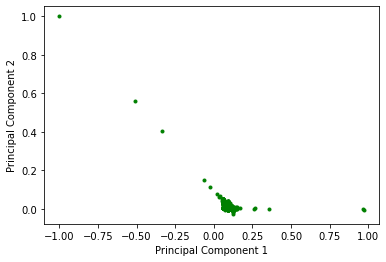

In [13]:
from itertools import cycle
from matplotlib import pyplot as plt
for k in range(len(d2)):
  plt.plot(d2[k,1],d2[k,0],  'g.')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()


## Observations from graph above
The datapoints obtained after scaling down and imputation, have some rather nasty outliers. These outliers would skew any analysis towards false centers and needs to be dealt with. These outlier occur due to the fact the unit of each observation is different and so is their quantity. 
Here, quantity takes a quality of its own and skew the data points after clustering.
So, these outlier points are initially estimated.

# Isolating the outliers
Here, isolation forest method is used to detect outliers.It returns the anomaly score of each sample using the IsolationForest algorithm

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

In [14]:
from sklearn.ensemble import IsolationForest


In [15]:
iso = IsolationForest(random_state = 0, max_features = 6)
d_ = iso.fit_predict(d2)

# Estimating the positions of the outliers

In [16]:
indi_1 = []
for i in range(len(d_)):
  if d_[i] == -1:
    indi_1.append(i)
print("The number of outliers are: ", len(indi_1))

The number of outliers are:  225


# Removing the outliers

In [17]:
d2 = np.delete(d2,indi_1,0)
print("The number of remaining elements are: ", len(d2))

The number of remaining elements are:  2054


## Operating Principal Component Analysis
As there are 6 features across each observation, this data set needs to be compressed in order to be viewed feasibly in 2 dimensional graphs. Principal Component analysis achieves this by reducing the number of features into 2 principal components based on their relative projections on the plane.

This stage has the functions that are responsible for dimensionality reduction. Upon conducting variance analysis, 2 factors account for 95% of the variance associated with the features. So, the number of components are kept 2.

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
d3 = pca.fit_transform(d2)
print("The variance ratio is: ", pca.explained_variance_ratio_)
print("and the singular values are: ", pca.singular_values_)

The variance ratio is:  [0.63158914 0.33344683]
and the singular values are:  [5.78576903 4.20394535]


# Output from PCA
Following plot shows the output for the dataset which are processed after PCA.

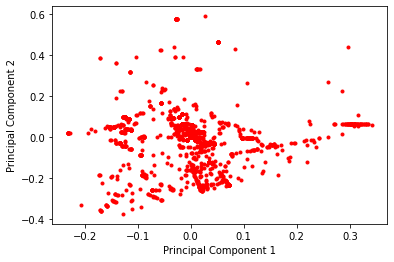

In [19]:
from itertools import cycle
from matplotlib import pyplot as plt
for k in range(len(d3)):
  plt.plot(d3[k,1],d3[k,0],  'r.')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()


# Clustering and Performance Evaluation
Algorithms like K-means, BIRCH and Affinity Propagation are implemented in these functions. It is linked to the evaluation metrics and the plotter functions which will plot the distributions of the 2 components with respect to each other.

Here due to the absence of any sort of categorical variables or any variables indicating the "ground truth", internal evaluation metrics like Silhouette coefficient, Calinski-Harabasz Index and Davies-Bouldin Index are used to measure the effectiveness of the clustering. These metrics measure the inter- and intra-cluster distances by using different approaches.

## K-Means Clustering

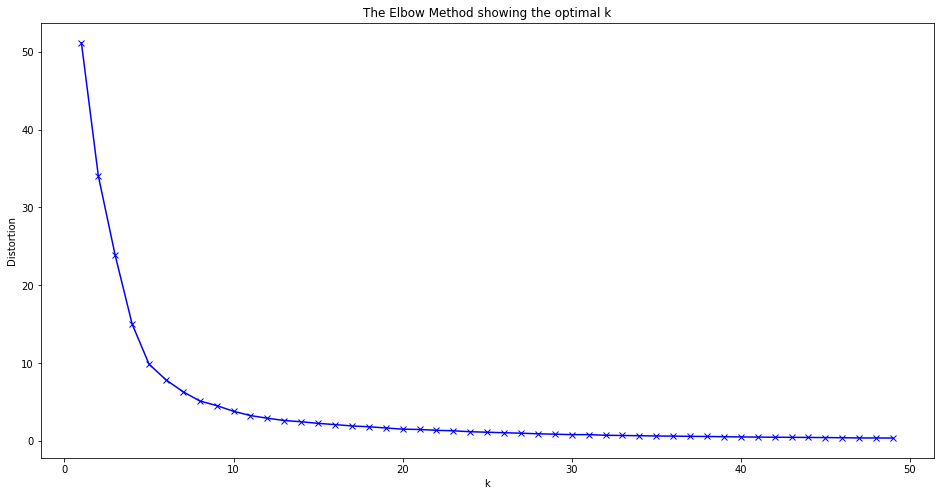

In [20]:
from sklearn.cluster import KMeans
distortions = []
K = range(1,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(d3)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


The point of inflexion for this curve would indicate a knee point, which would provide us with the ideal number of clusters. In this case it is near 5.

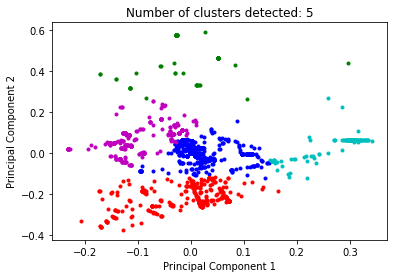

No. of clusters: 5
Silhoutte score is: 					   0.5254592488278931
Calinski - Harabasz Index score is:  2140.1591886998417
Davies-Bouldin score is: 			   0.6355548902373604


In [21]:
kmeans = KMeans(n_clusters=5, random_state = 0).fit(d3)
label = kmeans.fit_predict(d3)
u_labels = np.unique(label)
from itertools import cycle
from matplotlib import pyplot as plt
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(len(u_labels)), colors):
                my_members = label == k
                plt.plot(d3[my_members, 1], d3[my_members, 0], col + '.')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Number of clusters detected: %d' % len(u_labels))
plt.show()
print('No. of clusters:', len(u_labels))
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
sil = metrics.silhouette_score(d3, label, metric='euclidean')
print("Silhoutte score is: \t\t\t\t\t  ", sil)
ch = metrics.calinski_harabasz_score(d3,label)
print("Calinski - Harabasz Index score is: ", ch)
db = davies_bouldin_score(d3, label)
print("Davies-Bouldin score is: \t\t\t  ", db)

## BIRCH

No. of clusters 5


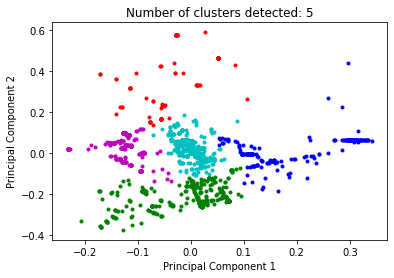

Silhoutte score is:  					   0.521507680736681
Calinski - Harabasz Index score is:  1683.6242432748102
Davies-Bouldin score is: 			   0.6978443570239267


In [22]:
from sklearn.cluster import Birch
BRC= Birch(threshold = 0.0, branching_factor=375, n_clusters = 5).fit(d3)
label1 = BRC.predict(d3)
u_label1 = np.unique(label1)

print('No. of clusters', len(u_label1))
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(len(u_label1)), colors):
                my_members = label1 == k
                plt.plot(d3[my_members, 1], d3[my_members, 0], col + '.')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Number of clusters detected: %d'% len(u_label1))
plt.show()
sil = metrics.silhouette_score(d3, label1, metric='euclidean')
print("Silhoutte score is:  \t\t\t\t\t  ", sil)
ch = metrics.calinski_harabasz_score(d3,label1)
print("Calinski - Harabasz Index score is: ", ch)
db = davies_bouldin_score(d3, label1)
print("Davies-Bouldin score is: \t\t\t  ", db)


## Agglomerative Hierarchical Clustering

No. of clusters 5


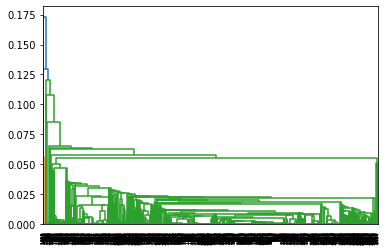

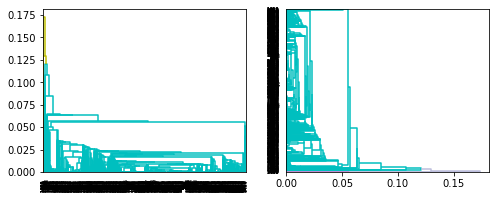

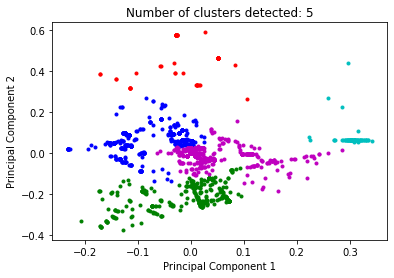

Silhoutte score is:  					   0.46011420995365215
Calinski - Harabasz Index score is:  1854.5224637098295
Davies-Bouldin score is: 			   0.6668705321730048


In [23]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
label3 = AgglomerativeClustering(n_clusters = 5).fit_predict(d3)
u_label3 = np.unique(label3)
print('No. of clusters', len(u_label3))
Z = hierarchy.linkage(d3, 'single')
plt.figure()
dn = hierarchy.dendrogram(Z)
hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
dn1 = hierarchy.dendrogram(Z, ax=axes[0], above_threshold_color='y',orientation='top')
dn2 = hierarchy.dendrogram(Z, ax=axes[1], above_threshold_color='#bcbddc',orientation='right')
hierarchy.set_link_color_palette(None)  
plt.show()
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(len(u_label3)), colors):
                my_members = label3 == k
                plt.plot(d3[my_members, 1], d3[my_members, 0], col + '.')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Number of clusters detected: %d'% len(u_label3))
plt.show()
sil = metrics.silhouette_score(d3, label3, metric='euclidean')
print("Silhoutte score is:  \t\t\t\t\t  ", sil)
ch = metrics.calinski_harabasz_score(d3,label3)
print("Calinski - Harabasz Index score is: ", ch)
db = davies_bouldin_score(d3, label3)
print("Davies-Bouldin score is: \t\t\t  ", db)

## Affinity Propagation

No. of clusters 42


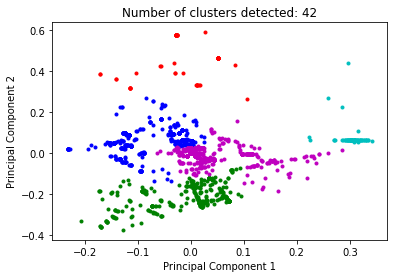

Silhoutte score is:  					   0.6047121243177627
Calinski - Harabasz Index score is:  4969.666108941415
Davies-Bouldin score is: 			   0.5471175907016865


In [24]:
from sklearn.cluster import AffinityPropagation
af = AffinityPropagation(damping = 0.85).fit(d3)
label4 = af.predict(d3)
u_label4 = np.unique(label4)
print('No. of clusters', len(u_label4))
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(len(u_label4)), colors):
                my_members = label3 == k
                plt.plot(d3[my_members, 1], d3[my_members, 0], col + '.')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Number of clusters detected: %d'% len(u_label4))
plt.show()
sil = metrics.silhouette_score(d3, label4, metric='euclidean')
print("Silhoutte score is:  \t\t\t\t\t  ", sil)
ch = metrics.calinski_harabasz_score(d3,label4)
print("Calinski - Harabasz Index score is: ", ch)
db = davies_bouldin_score(d3, label4)
print("Davies-Bouldin score is: \t\t\t  ", db)